This a modified copy of the notebook from [here](https://www.kaggle.com/tanulsingh077/end-to-end-object-detection-with-transformers-detr)

# DETR (Detection Transformer)

Attention is all you need,paper for Transformers,changed the state of NLP and has achieved great hieghts. Though mainly developed for NLP , the latest research around it focuses on how to leverage it across different verticals of deep learning. Transformer acrhitecture is very very powerful, and is something which is very close to my part,this is the reason I am motivated to explore anything that uses transformers , be it google's recently released Tabnet or OpenAI's ImageGPT .

Detection Transformer leverages the transformer network(both encoder and the decoder) for Detecting Objects in Images . Facebook's researchers argue that for object detection one part of the image should be in contact with the other part of the image for greater result especially with ocluded objects and partially visible objects, and what's better than to use transformer for it.

**The main motive behind DETR is effectively removing the need for many hand-designed components like a non-maximum suppression procedure or anchor generation that explicitly encode prior knowledge about the task and makes the process complex and computationally expensive**

The main ingredients of the new framework, called DEtection TRansformer or DETR, <font color='green'>are a set-based global loss that forces unique predictions via bipartite matching, and a transformer encoder-decoder architecture.</font>

![](https://cdn.analyticsvidhya.com/wp-content/uploads/2020/05/Screenshot-from-2020-05-27-17-48-38.png)


For Fully understanding DETR I recommend read [this](https://ai.facebook.com/blog/end-to-end-object-detection-with-transformers/) blog<br><br>
However if you want in-depth knowledge and are a video person like please see the video in the cell below
You can find the video in youtube [here](https://www.youtube.com/watch?v=T35ba_VXkMY)

In [1]:
!git clone https://github.com/facebookresearch/detr.git  /tmp/packages/detr #cloning github repo of detr to import its unique loss

Cloning into '/tmp/packages/detr'...
remote: Enumerating objects: 8, done.
remote: Counting objects: 100% (8/8), done.
remote: Compressing objects: 100% (7/7), done.
remote: Total 174 (delta 1), reused 5 (delta 1), pack-reused 166
Receiving objects: 100% (174/174), 12.82 MiB | 10.88 MiB/s, done.
Resolving deltas: 100% (76/76), done.


In [2]:
! ls /tmp/packages/detr/*

/tmp/packages/detr/Dockerfile  /tmp/packages/detr/main.py
/tmp/packages/detr/LICENSE     /tmp/packages/detr/requirements.txt
/tmp/packages/detr/README.md   /tmp/packages/detr/run_with_submitit.py
/tmp/packages/detr/engine.py   /tmp/packages/detr/test_all.py
/tmp/packages/detr/hubconf.py  /tmp/packages/detr/tox.ini

/tmp/packages/detr/d2:
README.md  configs  converter.py  detr	train_net.py

/tmp/packages/detr/datasets:
__init__.py  coco_eval.py      panoptic_eval.py
coco.py      coco_panoptic.py  transforms.py

/tmp/packages/detr/models:
__init__.py  detr.py	 position_encoding.py  transformer.py
backbone.py  matcher.py  segmentation.py

/tmp/packages/detr/util:
__init__.py  box_ops.py  misc.py  plot_utils.py


* Now if you have seen the video , you know that DETR uses a special loss called Bipartite Matching loss where it assigns one ground truth bbox to a predicted box using a matcher , thus when fine tuning we need the matcher (hungarian matcher as used in paper) and also the fucntion SetCriterion which gives Bipartite matching loss for backpropogation. This is the reason for forking the github repo

In [3]:
import os
import numpy as np 
import pandas as pd 
from datetime import datetime
import time
import random
from tqdm.auto import tqdm


#Torch
import torch
import torch.nn as nn
from torch.utils.data import Dataset,DataLoader
from torch.utils.data.sampler import SequentialSampler, RandomSampler

#sklearn
from sklearn.model_selection import StratifiedKFold

#CV
import cv2

################# DETR FUCNTIONS FOR LOSS######################## 
import sys
sys.path.extend(['/tmp/packages/detr/'])

from models.matcher import HungarianMatcher
from models.detr import SetCriterion
#################################################################

#Albumenatations
import albumentations as A
import matplotlib.pyplot as plt
from albumentations.pytorch.transforms import ToTensorV2

#Glob
from glob import glob

In [4]:
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        
    @property
    def avg(self):
        return (self.sum / self.count) if self.count>0 else 0

In [5]:
n_folds = 5
seed = 42
null_class_coef = 0.5
num_classes = 1
num_queries = 100
BATCH_SIZE = 8
LR = 5e-5
lr_dict = {'backbone':0.1,'transformer':1,'embed':1,'final': 5}
EPOCHS = 2
max_norm = 0
model_name = 'detr_resnet50'

# Seed Everything

Seeding everything for reproducible results

In [6]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

In [7]:
seed_everything(seed)

# Preparing the Data

* For preparation of data I use code from Alex's awesome kernel [here] (https://www.kaggle.com/shonenkov/training-efficientdet)
* The data can be split into any number of folds as you want , split is stratified based on number of boxes and source

In [8]:
marking = pd.read_csv('../input/global-wheat-detection/train.csv')

bboxs = np.stack(marking['bbox'].apply(lambda x: np.fromstring(x[1:-1], sep=',')))

for i, column in enumerate(['x', 'y', 'w', 'h']):
    marking[column] = bboxs[:,i] 
    
marking.drop(columns=['bbox'], inplace=True)

In [9]:
marking.head()

,image_id,width,height,source,x,y,w,h
0,b6ab77fd7,1024,1024,usask_1,834.0,222.0,56.0,36.0
1,b6ab77fd7,1024,1024,usask_1,226.0,548.0,130.0,58.0
2,b6ab77fd7,1024,1024,usask_1,377.0,504.0,74.0,160.0
3,b6ab77fd7,1024,1024,usask_1,834.0,95.0,109.0,107.0
4,b6ab77fd7,1024,1024,usask_1,26.0,144.0,124.0,117.0


In [10]:
image_data = marking.groupby('image_id')
images = list(map(lambda x: x.split('.')[0], os.listdir('../input/global-wheat-detection/train/')))

def get_data(img_id):
    if img_id not in image_data.groups:
        return dict(image_id=img_id, source='', boxes=list())
    
    data  = image_data.get_group(img_id)
    source = np.unique(data.source.values)
    assert len(source)==1, 'corrupted data: %s image_id has many sources: %s' %(img_id,source)
    source=source[0]
    boxes = data[['x','y','w','h']].values
    return dict(image_id = img_id, source=source, boxes = boxes)

image_list = [get_data(img_id) for img_id in images]
    


In [11]:
print(f'total number of images: {len(image_list)}, images with bboxes: {len(image_data)}')
null_images=[x['image_id'] for x in image_list if len(x['boxes'])==0]
len(null_images)



total number of images: 3422, images with bboxes: 3373


49

In [12]:
def add_fold_index(lst,n_folds):
    lens = [len(x['boxes']) for x in lst]
    lens_unique = np.unique(lens)
    i = np.random.randint(n_folds)
    fold_indexes = [[] for _ in range(n_folds)]
    idx = []
    
    for _l in lens_unique:
        idx.extend(np.nonzero(lens==_l)[0].tolist())
        if len(idx)<n_folds: continue
        random.shuffle(idx)
        while len(idx)>= n_folds:
            fold_indexes[i].append(lst[idx.pop()]['image_id'])
            i = (i+1) % n_folds
    while len(idx):
        fold_indexes[i].append(lst[idx.pop()]['image_id'])
        i = (i+1) % n_folds
    
    return fold_indexes
    
sources = np.unique([x['source'] for x in image_list])
splitted_image_list = {s:sorted([x for x in image_list if x['source']==s],key=lambda x: len(x['boxes'])) 
                       for s in sources}
splitted_image_list = {k: add_fold_index(v,n_folds=n_folds) for k,v in splitted_image_list.items()}

fold_indexes = [[] for _ in range(n_folds)]
for k,v in splitted_image_list.items():
    for i in range(n_folds):
        fold_indexes[i].extend(v[i])  
    
print([len(v) for v in fold_indexes])

[685, 684, 684, 684, 685]


In [13]:
if False:
    plt.figure(figsize=(10,10))
    for i,img in enumerate(null_images):
        plt.subplot(7,7,i+1)
        plt.imshow(plt.imread(f'../input/global-wheat-detection/train/{img}.jpg'))
        plt.axis('off')
        plt.axis('tight')
        plt.axis('equal')

    plt.show()

# Augmentations

* As suggested by aleksendra in her kernel ,augentations will play a major role and hence took her up advice and use awesome augmentations , cut-mix and other will be included in future versions

In [14]:
def get_train_transforms():
    return A.Compose(
        [
            A.OneOf(
            [
                A.HueSaturationValue(hue_shift_limit=0.2, sat_shift_limit= 0.2, val_shift_limit=0.2, p=0.9),      
                A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=0.9)
            ],
            p=0.9),         
            #A.ToGray(p=0.01),         
            A.HorizontalFlip(p=0.5),         
            A.VerticalFlip(p=0.5),         
            A.Resize(height=512, width=512, p=1),      
            A.Normalize(max_pixel_value=1),
            #A.Cutout(num_holes=8, max_h_size=32, max_w_size=32, fill_value=0, p=0.5),
            ToTensorV2(p=1.0)
        ], 
        p=1.0,         
        bbox_params=A.BboxParams(format='coco',min_area=0, min_visibility=0,label_fields=['labels'])
        )

def get_valid_transforms():
    return A.Compose([A.Resize(height=512, width=512, p=1.0),
                      A.Normalize(max_pixel_value=1),
                      ToTensorV2(p=1.0),
                      ], 
                      p=1.0, 
                      bbox_params=A.BboxParams(format='coco',min_area=0, min_visibility=0,label_fields=['labels'])
                      )

# Creating Dataset

* I hope you have the video by now , DETR accepts data in coco format which is (x,y,w,h)(for those who do not know there are two formats coco and pascal(smin,ymin,xmax,ymax) which are widely used) . So now we need to prepare data in that format

In [15]:
DIR_TRAIN = '../input/global-wheat-detection/train'
class WheatDataset(Dataset):
    def __init__(self,image_list,transforms=None):
        self.images = image_list
        self.transforms = transforms
        self.img_ids = {x['image_id']:i for i,x in enumerate(image_list)}
        
    def get_indices(self,img_ids):
        return [self.img_ids[x] for x in img_ids]
        
    def __len__(self) -> int:
        return len(self.images)
    
    def __getitem__(self,index):
        record = self.images[index]
        image_id = record['image_id']

        image = cv2.imread(f'{DIR_TRAIN}/{image_id}.jpg', cv2.IMREAD_COLOR)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)
        image /= 255.0
        
        # DETR takes in data in coco format 
        boxes = record['boxes'] 
        
        labels =  np.zeros(len(boxes), dtype=np.int32)

        if self.transforms:
            sample = {
                'image': image,
                'bboxes': boxes,
                'labels': labels
            }
            sample = self.transforms(**sample)
            image  = sample['image']
            boxes  = sample['bboxes']
            labels = sample['labels']

        _,h,w = image.shape
        boxes = A.augmentations.bbox_utils.normalize_bboxes(sample['bboxes'],rows=h,cols=w)
        ## detr uses center_x,center_y,width,height !!
        if len(boxes)>0:
            boxes = np.array(boxes)
            boxes[:,2:] /= 2
            boxes[:,:2] += boxes[:,2:]
        else:
            boxes = np.zeros((0,4))
    
        target = {}
        target['boxes'] = torch.as_tensor(boxes,dtype=torch.float32)
        target['labels'] = torch.as_tensor(labels,dtype=torch.long)
        target['image_id'] = torch.tensor([index])
        
        return image, target, image_id

In [16]:
train_ds = WheatDataset(image_list,get_train_transforms())
valid_ds = WheatDataset(image_list,get_valid_transforms())

In [17]:
def show_example(image,target,image_id=None):
    np_image = image.cpu().numpy().transpose((1,2,0))
    # unnormalize the image
    np_image = np_image*np.array([0.229, 0.224, 0.225])+np.array([0.485, 0.456, 0.406])
    #np_image = (np_image*255).astype(np.uint8)
    target = {k: v.cpu().numpy() for k, v in target.items()} 
    
    boxes = target['boxes']
    h,w,_ = np_image.shape
    boxes = [np.array(box).astype(np.int32) for box in A.augmentations.bbox_utils.denormalize_bboxes(boxes,h,w)]
        
    fig, ax = plt.subplots(1, 1, figsize=(16, 8))

    for box in boxes:
        cv2.rectangle(np_image,
                  (box[0]-box[2], box[1]-box[3]),
                  (box[2]+box[0], box[3]+box[1]),
                  (220, 0, 0), 1)
        
    ax.set_axis_off()
    ax.imshow(np_image)
    ax.set_title(image_id)
    plt.show()

    

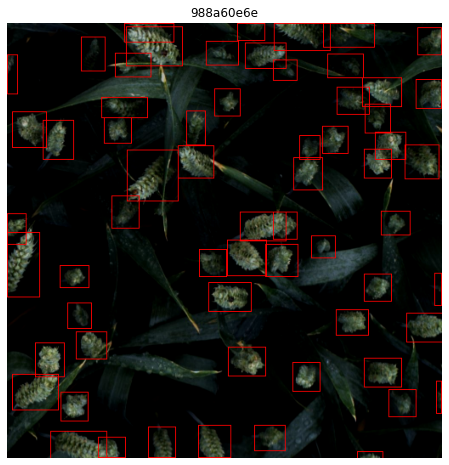

In [18]:
show_example(*train_ds[350])

# Model

* Initial DETR model is trained on coco dataset , which has 91 classes + 1 background class , hence we need to modify it to take our own number of classes
* Also DETR model takes in 100 queries ie ,it outputs total of 100 bboxes for every image , we can very well change that too

In [19]:
#torch.hub.load?

In [20]:
def DETRModel(num_classes,model_name=model_name):
    model = torch.hub.load('facebookresearch/detr', model_name, pretrained=False, num_classes=num_classes)
    def parameter_groups(self):
        return { 'backbone': [p for n,p in self.named_parameters()
                              if ('backbone' in n) and p.requires_grad],
                 'transformer': [p for n,p in self.named_parameters() 
                                 if (('transformer' in n) or ('input_proj' in n)) and p.requires_grad],
                 'embed': [p for n,p in self.named_parameters()
                                 if (('class_embed' in n) or ('bbox_embed' in n) or ('query_embed' in n)) 
                           and p.requires_grad]}
    setattr(type(model),'parameter_groups',parameter_groups)
    return model

class DETRModel(nn.Module):
    def __init__(self,num_classes=1):
        super(DETRModel,self).__init__()
        self.num_classes = num_classes
        
        self.model = torch.hub.load('facebookresearch/detr', model_name, pretrained=True)
        
        self.out = nn.Linear(in_features=self.model.class_embed.out_features,out_features=num_classes+1)
        
    def forward(self,images):
        d = self.model(images)
        d['pred_logits'] = self.out(d['pred_logits'])
        return d
    
    def parameter_groups(self):
        return { 
            'backbone': [p for n,p in self.model.named_parameters()
                              if ('backbone' in n) and p.requires_grad],
            'transformer': [p for n,p in self.model.named_parameters() 
                                 if (('transformer' in n) or ('input_proj' in n)) and p.requires_grad],
            'embed': [p for n,p in self.model.named_parameters()
                                 if (('class_embed' in n) or ('bbox_embed' in n) or ('query_embed' in n)) 
                           and p.requires_grad],
            'final': self.out.parameters()
            }

In [21]:
model = DETRModel()
model.parameter_groups().keys()
#type(model)

Downloading: "https://github.com/facebookresearch/detr/archive/master.zip" to /root/.cache/torch/hub/master.zip
Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/hub/checkpoints/resnet50-19c8e357.pth


Downloading: "https://dl.fbaipublicfiles.com/detr/detr-r50-e632da11.pth" to /root/.cache/torch/hub/checkpoints/detr-r50-e632da11.pth


dict_keys(['backbone', 'transformer', 'embed', 'final'])

# Matcher and Bipartite Matching Loss

Now we make use of the unique loss that the model uses and for that we need to define the matcher. DETR calcuates three individual losses :
* Classification Loss for labels(its weight can be set by loss_ce)
* Bbox Loss (its weight can be set by loss_bbox)
* Loss for Background class

In [22]:
'''
code taken from github repo detr , 'code present in engine.py'
'''

matcher = HungarianMatcher(cost_giou=2,cost_class=1,cost_bbox=5)

weight_dict = {'loss_ce': 1, 'loss_bbox': 5 , 'loss_giou': 2}

losses = ['labels', 'boxes', 'cardinality']

In [23]:
def collate_fn(batch):
    return tuple(zip(*batch))

In [24]:
def get_fold(fold):
    
    train_indexes = train_ds.get_indices([x for i,f in enumerate(fold_indexes) if i!=fold for x in f])
    valid_indexes = valid_ds.get_indices(fold_indexes[fold])
    
    train_data_loader = DataLoader(
        torch.utils.data.Subset(train_ds,train_indexes),
        batch_size=BATCH_SIZE,
        shuffle=True,
        num_workers=2,
        collate_fn=collate_fn
    )

    valid_data_loader = DataLoader(
        torch.utils.data.Subset(valid_ds,valid_indexes),
        batch_size=BATCH_SIZE,
        shuffle=False,
        num_workers=2,
        collate_fn=collate_fn
    )
    return train_data_loader,valid_data_loader


In [25]:
train_loader,valid_loader = get_fold(0)

In [26]:
valid_iter = iter(valid_loader)
batch  = next(valid_iter)
#batch  = next(valid_iter)


In [27]:
images,targets,image_id = batch
torch.cat([v['boxes'] for v in targets])

tensor([], size=(0, 4))

In [28]:
import util.box_ops  as box_ops

def challenge_metric(outputs,targets):
    logits = outputs['pred_logits']
    boxes  = outputs['pred_boxes']
    return sum(avg_precision(logit[:,0]-logit[:,1],box,target['boxes'])
            for logit,box,target in zip(logits,boxes,targets))/len(logits)

    return {target['image_id']:avg_precision(logit[:,0]-logit[:,1],box,target['boxes'])
            for logit,box,target in zip(logits,boxes,targets)}


@torch.no_grad()
def avg_precision(logit,pboxes,tboxes,reduce=True):
    idx = logit.gt(0)
    if sum(idx)==0 and len(tboxes)==0: 
        return 1 if reduce else [1]*6
    if sum(idx)>0 and len(tboxes)==0: 
        return 0 if reduce else [0]*6
    
    pboxes = pboxes[idx]
    logit = logit[idx]
    
    idx = logit.argsort(descending=True)
    pboxes=box_ops.box_cxcywh_to_xyxy(pboxes.detach()[idx])
    tboxes=box_ops.box_cxcywh_to_xyxy(tboxes)
    
    iou = box_ops.box_iou(pboxes,tboxes)[0].cpu().numpy()
    prec = [precision(iou,th) for th in [0.5,0.55,0.6,0.65,0.7,0.75]]
    if reduce:
        return sum(prec)/6
    return prec
    

def precision(iou,th):
    #if iou.shape==(0,0): return 1

    #if min(*iou.shape)==0: return 0
    tp = 0
    iou = iou.copy()
    num_pred,num_gt = iou.shape
    for i in range(num_pred):
        _iou = iou[i]
        n_hits = (_iou>th).sum()
        if n_hits>0:
            tp += 1
            j = np.argmax(_iou)
            iou[:,j] = 0
    return tp/(num_pred+num_gt-tp)
    

In [29]:
def gen_box(n,scale=1):
    par = torch.randn((n,4)).mul(scale).sigmoid() 
    max_hw = 2*torch.min(par[:,:2],1-par[:,:2])
    par[:,2:] = par[:,2:].min(max_hw)
    return par

pboxes = gen_box(50)
logit = torch.randn(50)
tboxes = gen_box(3) 
#iou = 
avg_precision(logit,pboxes,tboxes)
#iou.gt(0.5),iou,pboxes,tboxes

0.015151515151515152

# Training Function

Training of DETR is unique and different from FasteRRcnn  and EfficientDET , as we train the criterion as well , the training function can be viewed here : https://github.com/facebookresearch/detr/blob/master/engine.py

In [30]:
def train_fn(data_loader,model,criterion,optimizer,device,scheduler,epoch):
    model.train()
    criterion.train()
    
    tk0 = tqdm(data_loader, total=len(data_loader),leave=False)
    log = None
    
    for step, (images, targets, image_ids) in enumerate(tk0):
        
        batch_size = len(images)
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
        

        output = model(images)
        
        loss_dict = criterion(output, targets)
        
        if log is None:
            log = {k:AverageMeter() for k in loss_dict}
            log['total_loss'] = AverageMeter()
            log['avg_prec'] = AverageMeter()
            
        weight_dict = criterion.weight_dict
        
        total_loss = sum(loss_dict[k] * weight_dict[k] for k in loss_dict.keys() if k in weight_dict)
        
        optimizer.zero_grad()

        total_loss.backward()
        
        if max_norm > 0:
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm)
        
        optimizer.step()
        
        if scheduler is not None:
            scheduler.step()
        
        log['total_loss'].update(total_loss.item(),batch_size)
        
        for k,v in loss_dict.items():
            log[k].update(v.item(),batch_size)
            
        log['avg_prec'].update(challenge_metric(output,targets),batch_size)
            
        tk0.set_postfix({k:v.avg for k,v in log.items()}) 
        
    return log

# Eval Function

In [31]:
def eval_fn(data_loader, model,criterion, device):
    model.eval()
    criterion.eval()
    log = None
    
    with torch.no_grad():
        
        tk0 = tqdm(data_loader, total=len(data_loader),leave=False)
        for step, (images, targets, image_ids) in enumerate(tk0):
            
            batch_size = len(images)
            
            images = list(image.to(device) for image in images)
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

            output = model(images)
        
            loss_dict = criterion(output, targets)
            weight_dict = criterion.weight_dict
        
            if log is None:
                log = {k:AverageMeter() for k in loss_dict}
                log['total_loss'] = AverageMeter()
                log['avg_prec'] = AverageMeter()
            
            for k,v in loss_dict.items():
                log[k].update(v.item(),batch_size)
        
            total_loss = sum(loss_dict[k] * weight_dict[k] for k in loss_dict.keys() if k in weight_dict)
            log['total_loss'].update(total_loss.item(),batch_size)
            log['avg_prec'].update(challenge_metric(output,targets),batch_size)
            
            tk0.set_postfix({k:v.avg for k,v in log.items()}) 
    
    return log #['total_loss']

# Engine

In [32]:
import json

class Logger:
    def __init__(self,filename,format='csv'):
        self.filename = filename + '.' + format
        self._log = []
        self.format = format
    def save(self,log,epoch=None):
        log['epoch'] = epoch+1
        self._log.append(log)
        if self.format == 'json':
            with open(self.filename,'w') as f:
                json.dump(self._log,f)
        else:
            pd.DataFrame(self._log).to_csv(self.filename,index=False)
            
            
def run(fold,epochs=EPOCHS):
    
    train_data_loader,valid_data_loader = get_fold(fold)
    
    logger = Logger(f'log_{fold}')
    device = torch.device('cuda')
    model = DETRModel(num_classes=num_classes)
    model = model.to(device)
    criterion = SetCriterion(num_classes, 
                             matcher, weight_dict, 
                             eos_coef = null_class_coef, 
                             losses=losses)
    
    criterion = criterion.to(device)
    

    optimizer = torch.optim.AdamW([{
        'params': v,
        'lr': lr_dict.get(k,1)*LR
    } for k,v in model.parameter_groups().items()], weight_decay=1e-4)
    
    best_precision = 0
    header_printed = False
    for epoch in range(epochs):
        train_log = train_fn(train_data_loader, model,criterion, optimizer,device,scheduler=None,epoch=epoch)
        valid_log = eval_fn(valid_data_loader, model,criterion, device)
    
        log = {k:v.avg for k,v in train_log.items()}
        log.update({'V/'+k:v.avg for k,v in valid_log.items()})
        logger.save(log,epoch)
        keys = sorted(log.keys())
        
        if not header_printed:
            print(' '.join(map(lambda k: f'{k[:8]:8}',keys)))
            header_printed = True
        print(' '.join(map(lambda k: f'{log[k]:8.3f}'[:8],keys)))
        
        if log['V/avg_prec'] > best_precision:
            best_precision = log['V/avg_prec']
            print('Best model found at epoch {}'.format(epoch+1))
            torch.save(model.state_dict(), f'detr_best_{fold}.pth')
        

In [33]:
import gc
gc.collect()

33

In [34]:
run(fold=0,epochs=50)

Using cache found in /root/.cache/torch/hub/facebookresearch_detr_master


V/avg_pr V/cardin V/class_ V/loss_b V/loss_c V/loss_g V/total_ avg_prec cardinal class_er epoch    loss_bbo loss_ce  loss_gio total_lo
   0.102   15.226   14.503    0.053    0.409    0.711    2.098    0.060   19.650   20.244    1.000    0.081    0.551    0.890    2.734
Best model found at epoch 1


   0.131    9.787   15.994    0.047    0.370    0.659    1.925    0.105   10.856   15.331    2.000    0.058    0.416    0.759    2.222
Best model found at epoch 2


   0.163    7.559   16.062    0.043    0.337    0.631    1.812    0.132    9.828   13.948    3.000    0.050    0.388    0.706    2.048
Best model found at epoch 3


   0.179    7.380   14.371    0.040    0.322    0.603    1.730    0.147    8.393   12.968    4.000    0.046    0.363    0.674    1.943
Best model found at epoch 4


   0.190    6.315   14.853    0.040    0.305    0.597    1.701    0.155    7.931   12.283    5.000    0.046    0.348    0.666    1.911
Best model found at epoch 5


   0.190   10.350   11.000    0.036    0.314    0.576    1.643    0.168    7.512   12.028    6.000    0.043    0.338    0.645    1.841
Best model found at epoch 6


   0.194    6.149   13.656    0.038    0.294    0.576    1.635    0.173    7.529   11.681    7.000    0.042    0.333    0.640    1.825
Best model found at epoch 7


   0.192    5.477   14.507    0.039    0.290    0.594    1.669    0.167    7.452   11.435    8.000    0.044    0.332    0.649    1.848


   0.202    5.872   12.356    0.037    0.271    0.572    1.600    0.191    6.593   10.723   11.000    0.039    0.310    0.614    1.731


   0.212    6.197   11.107    0.034    0.271    0.561    1.565    0.194    6.168   10.776   12.000    0.041    0.303    0.624    1.756


   0.245    5.521   11.935    0.034    0.255    0.531    1.485    0.211    6.336   10.469   18.000    0.037    0.300    0.591    1.666


   0.229    6.927    9.728    0.032    0.267    0.534    1.497    0.214    6.054   10.620   24.000    0.037    0.297    0.590    1.661


   0.232    5.161   11.638    0.035    0.256    0.550    1.530    0.200    6.247   10.090   25.000    0.039    0.297    0.606    1.706


   0.242    6.953   10.040    0.031    0.258    0.526    1.463    0.206    5.931   10.386   41.000    0.039    0.291    0.606    1.696


   0.250    4.380   11.697    0.031    0.243    0.525    1.447    0.216    6.006    9.607   42.000    0.036    0.279    0.591    1.643


# Sample

* I know we might be naive to visualize the model ouput just after one epoch but lets do that and see what are the results like

In [35]:
def show_predictions(images,outputs,targets):
    _,h,w = images[0].shape
    
    boxes = targets[0]['boxes'].cpu().numpy() #.astype(np.int32)
    boxes = [np.array(box).astype(np.int32) for box in A.augmentations.bbox_utils.denormalize_bboxes(boxes,h,w)]
    np_image = images[0].permute(1,2,0).cpu().numpy()
    np_image = np_image*np.array([0.229, 0.224, 0.225])+np.array([0.485, 0.456, 0.406])
    
    #outputs = [{k: v.cpu() for k, v in output.items()}]
    
    fig, ax = plt.subplots(1, 1, figsize=(16, 8))

    for box in boxes:
        cv2.rectangle(np_image,
                  (box[0]-box[2], box[1]-box[3]),
                  (box[2]+box[0], box[3]+box[1]),
                  (220, 0, 0), 2)
    
    oboxes = outputs['pred_boxes'][0].detach().cpu().numpy()
    oboxes = [np.array(box).astype(np.int32) for box in A.augmentations.bbox_utils.denormalize_bboxes(oboxes,h,w)]
    prob   = outputs['pred_logits'][0].softmax(1).detach().cpu().numpy()[:,0]
    for box,p in zip(oboxes,prob):
        if p>0.5:
            color = (0,0,220) if p>0.5 else (0,220,0)
            cv2.rectangle(np_image,
                      (box[0]-box[2], box[1]-box[3]),
                      (box[2]+box[0], box[3]+box[1]),
                      color, 1)
    
    ax.set_axis_off()
    ax.imshow(np_image)
    #return images,outputs,targets

In [36]:
model = DETRModel(num_classes=num_classes,num_queries=num_queries)
model.load_state_dict(torch.load("./detr_best_0.pth"))
model.to(torch.device('cuda'))
None

TypeError: __init__() got an unexpected keyword argument 'num_queries'

In [37]:
train_loader,valid_loader = get_fold(0)
valid_iter = iter(valid_loader)



In [38]:
images,targets,image_id = next(valid_iter)
dev_images = [img.to(torch.device('cuda')) for img in images]
model.eval()
with torch.no_grad():
    outputs = model(dev_images)
outputs = {k: v.cpu() for k, v in outputs.items()}
show_predictions(images,outputs,targets)

RuntimeError: Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same

In [39]:
def postprocess(output):
    logits  = output['pred_logits'][0]
    idx     = (logits[:,0]-logits[:,1]).gt(0)
    return {'pred_logits': logits[idx,0]-logits[idx,1],'pred_boxes':output['pred_boxes'][0][idx]}

In [40]:
logit = outputs['pred_logits'][0]
prec = avg_precision(logit[:,0]-logit[:,1],outputs['pred_boxes'][0],targets[0]['boxes'],reduce=False)
prec,sum(prec)/len(prec),(logit[:,0]-logit[:,1]).gt(0)

NameError: name 'outputs' is not defined

In [41]:
outputs['pred_logits'][0].softmax(1).detach().cpu().numpy()[:,0]
#len(targets[0]['labels']),len(targets[0]['boxes'])

NameError: name 'outputs' is not defined